In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

from tf_aerial_images import *

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
NUM_CHANNELS = 3  # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
TRAINING_SIZE = 20
VALIDATION_SIZE = 5  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 16  # 64
NUM_EPOCHS = 100
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
RECORDING_STEP = 0

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 16

# tf.app.flags.DEFINE_string(
#     "train_dir",
#     "/tmp/segment_aerial_images",
#     """Directory where to write event logs """ """and checkpoint.""",
# )
# FLAGS = tf.app.flags.FLAGS


# Extract patches from a given image
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches


def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print("Loading " + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print("File " + image_filename + " does not exist")

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH / IMG_PATCH_SIZE) * (IMG_HEIGHT / IMG_PATCH_SIZE)

    img_patches = [
        img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)
    ]
    data = [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]

    return numpy.asarray(data)


# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]


# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print("Loading " + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print("File " + image_filename + " does not exist")

    num_images = len(gt_imgs)
    gt_patches = [
        img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)
    ]
    data = numpy.asarray(
        [
            gt_patches[i][j]
            for i in range(len(gt_patches))
            for j in range(len(gt_patches[i]))
        ]
    )
    labels = numpy.asarray(
        [value_to_class(numpy.mean(data[i])) for i in range(len(data))]
    )

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

In [3]:
data_dir = "./data/training/training/"
train_data_filename = data_dir + "images/"
train_labels_filename = data_dir + "groundtruth/"


In [4]:
# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)

Loading ./data/training/training/images/satImage_001.png
Loading ./data/training/training/images/satImage_002.png
Loading ./data/training/training/images/satImage_003.png
Loading ./data/training/training/images/satImage_004.png
Loading ./data/training/training/images/satImage_005.png
Loading ./data/training/training/images/satImage_006.png
Loading ./data/training/training/images/satImage_007.png
Loading ./data/training/training/images/satImage_008.png
Loading ./data/training/training/images/satImage_009.png
Loading ./data/training/training/images/satImage_010.png
Loading ./data/training/training/images/satImage_011.png
Loading ./data/training/training/images/satImage_012.png
Loading ./data/training/training/images/satImage_013.png
Loading ./data/training/training/images/satImage_014.png
Loading ./data/training/training/images/satImage_015.png
Loading ./data/training/training/images/satImage_016.png
Loading ./data/training/training/images/satImage_017.png
Loading ./data/training/trainin

In [5]:
#train_data[0] correspond to RGB of one patche
print(train_data.shape)
#print(train_labels)

(12500, 16, 16, 3)


In [6]:
#num_epochs = NUM_EPOCHS
num_epochs = 200

c0 = 0  # bgrd
c1 = 0  # road
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print("Number of data points per class: c0 = " + str(c0) + " c1 = " + str(c1))
print("Balancing training data...")
min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(train_labels) if j[0] == 1]
idx1 = [i for i, j in enumerate(train_labels) if j[1] == 1]
new_indices = idx0[0:min_c] + idx1[0:min_c]
print(len(new_indices))
print(train_data.shape)
train_data = train_data[new_indices, :, :, :]
train_labels = train_labels[new_indices]
train_size = train_labels.shape[0]
c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print("Number of data points per class: c0 = " + str(c0) + " c1 = " + str(c1))
print(train_data.shape)

Number of data points per class: c0 = 9450 c1 = 3050
Balancing training data...
6100
(12500, 16, 16, 3)
Number of data points per class: c0 = 3050 c1 = 3050
(6100, 16, 16, 3)


In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load image and label at the given index
        image = self.data[idx]
        
        # Convert numpy array to PyTorch tensor and permute to (C, H, W)
        # Because pytorch tensor have a different shape (3, 16, 16) instead of (16, 16, 3)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) to (C, H, W)
        if self.labels is not None:
            label = self.labels[idx]
            label = torch.tensor(label, dtype=torch.float32)
        else:
            label = None  # No label provided for test/inference mode

        # Apply any transforms if specified
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            return image, label
        else:
            return image

# Create the dataset and dataloader

# Similar to TensorDataset (default Dataset from pytorch) or torchvision.datasets.MNIST("./mnist/", train=True, download=True, transform=transform)
# If we want to add Transformation do:
# transform = transforms.Compose(#write sth inside)
#train_dataset = CustomDataset(train_data, train_labels, transform=transform)
train_dataset = CustomDataset(train_data, train_labels)
# Roles of DataLoader
# Batches and shuffles data as it loads.
# Provides an iterator over the data to simplify iteration in training loops.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
#Here we attempt to create the same kind of model as in tf_aerial_images.py
#But using pytorch instead of tensorflow
class CNN_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_Model, self).__init__()
        
        # Define convolutional layers
        #in channels is the 3 RGB channels. Out_channels are 16, it means 16 filters. 
        # And each filter is applied to each of the 3 RGB channels and them summed up.
        # Shape: (num_patches, 3, 16, 16) -> (num_patches, 16, 16, 16)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # SAME padding (=1) => no size reduction for patches
        self.relu1 = nn.ReLU()  # ReLU after conv1
        # Shape: (num_patches, 16, 16, 16) -> (num_patches, 32, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # SAME padding (=1) => no size reduction for patches
        self.relu2 = nn.ReLU()
        # Max pooling layer
        # Shape: (num_patches, 32, 16, 16) -> (num_patches, 32, 8, 8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        #(num_patches, 32, 8, 8) -> (num_patches, 32, 1, 1)
        self.pool2 = torch.nn.AdaptiveAvgPool2d(1)
        self.conv_final = torch.nn.Conv2d(32, num_classes, kernel_size=1)
        self.flatten = torch.nn.Flatten()
        


    def forward(self, x, train=False):
        # First convolution, ReLU
        x = self.relu1(self.conv1(x))  # Conv1 -> ReLU -> MaxPool
        
        # Second convolution, ReLU, and pooling
        x = self.pool(self.relu2(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        
        x = self.pool2(self.relu3(x))
        x = self.conv_final(x)
        x = self.flatten(x)
        
        return x

In [9]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    ### SOLUTION
    model.train()
    loss_history = []
    accuracy_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        
        #Come back from one-hot
        target_comp = target[:, 1].unsqueeze(dim=1)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target_comp.view_as(pred)).sum().item()

        loss_history.append(loss.item())
        accuracy_history.append(correct / len(data))
        print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e} batch_acc={correct/len(data):0.3f}"
            )
    return loss_history, accuracy_history

In [10]:
# ===== Model, Optimizer and Criterion =====
def run_CNN_training(num_epochs, lr, data, device="cpu"):
    model = CNN_Model()
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.functional.cross_entropy
    # ===== Train Model =====
    train_loss_history = []
    train_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(
            model, device, data, optimizer, epoch, criterion
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)

    n_train = len(train_acc_history)
    return train_acc_history, train_loss_history, model
    # plt.figure()
    # plt.plot(t_train, train_acc_history, label="Train")
    # plt.legend()
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy")

    # plt.figure()
    # plt.plot(t_train, train_loss_history, label="Train")
    # plt.legend()
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.show()

In [11]:
#Run on a subset of train_loader
total_size = len(train_dataset)
print(total_size)
subset_size = 1000
subset_indices = np.random.choice(total_size, size=subset_size, replace=False)

# 2. Create the subset dataset
subset_train_dataset = Subset(train_dataset, subset_indices)

# 3. Create a DataLoader for the subset
subset_train_loader = DataLoader(subset_train_dataset, batch_size=32, shuffle=True)
print(len(subset_train_loader))

6100
32


In [12]:
lr = 5e-4
train_acc_history, train_loss_history, model = run_CNN_training(num_epochs, lr, train_loader)

Train Epoch: 1-0 batch_loss=2.18e-02 batch_acc=0.438
Train Epoch: 1-1 batch_loss=2.17e-02 batch_acc=0.469
Train Epoch: 1-2 batch_loss=2.16e-02 batch_acc=0.531
Train Epoch: 1-3 batch_loss=2.16e-02 batch_acc=0.500
Train Epoch: 1-4 batch_loss=2.16e-02 batch_acc=0.406
Train Epoch: 1-5 batch_loss=2.17e-02 batch_acc=0.406
Train Epoch: 1-6 batch_loss=2.17e-02 batch_acc=0.500
Train Epoch: 1-7 batch_loss=2.16e-02 batch_acc=0.562
Train Epoch: 1-8 batch_loss=2.16e-02 batch_acc=0.688
Train Epoch: 1-9 batch_loss=2.16e-02 batch_acc=0.656
Train Epoch: 1-10 batch_loss=2.16e-02 batch_acc=0.625
Train Epoch: 1-11 batch_loss=2.16e-02 batch_acc=0.562
Train Epoch: 1-12 batch_loss=2.17e-02 batch_acc=0.469
Train Epoch: 1-13 batch_loss=2.15e-02 batch_acc=0.750
Train Epoch: 1-14 batch_loss=2.16e-02 batch_acc=0.656
Train Epoch: 1-15 batch_loss=2.16e-02 batch_acc=0.625
Train Epoch: 1-16 batch_loss=2.17e-02 batch_acc=0.500
Train Epoch: 1-17 batch_loss=2.17e-02 batch_acc=0.531
Train Epoch: 1-18 batch_loss=2.17e-02 

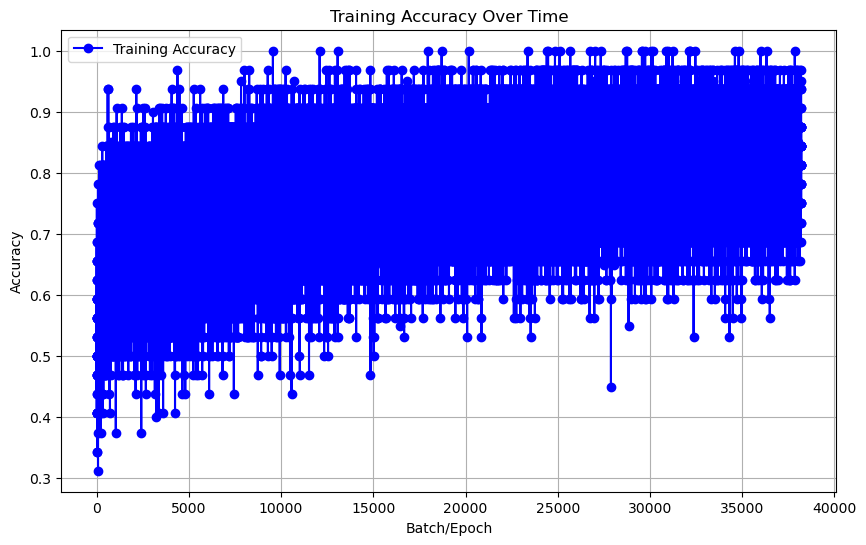

In [13]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot the accuracy history
plt.plot(train_acc_history, label='Training Accuracy', color='blue', marker='o')

# Add title and labels
plt.title('Training Accuracy Over Time')
plt.xlabel('Batch/Epoch')
plt.ylabel('Accuracy')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.show()

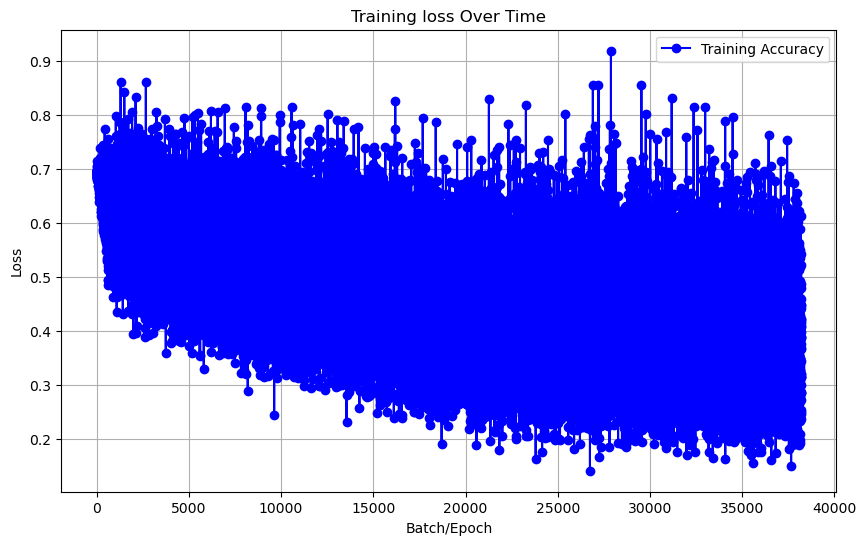

In [14]:
plt.figure(figsize=(10, 6))

# Plot the accuracy history
plt.plot(train_loss_history, label='Training Accuracy', color='blue', marker='o')

# Add title and labels
plt.title('Training loss Over Time')
plt.xlabel('Batch/Epoch')
plt.ylabel('Loss')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.show()

**Let's check what effect does our model on training set**

We load a specific image from training set

In [15]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [16]:
root_dir = "./data/training/training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(1, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
img = imgs[0]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_img = gt_imgs[0]
print(files[0])

Loading 1 images
satImage_001.png
Loading 1 images
satImage_001.png


In [17]:
gt_patches = [
        img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(1)
    ]
data = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)
labels = np.asarray(
    [value_to_class(numpy.mean(data[i])) for i in range(len(data))]
)
print(labels.shape)

(625, 2)


In [18]:
img_patches = img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE)
data = [
        img_patches[i]
        for i in range(len(img_patches))
    ]
img_cro = np.asarray(data)
print(img_cro.shape)

(625, 16, 16, 3)


In [19]:
@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    preds = []
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        #print(data)
        output = model(data)
        #loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)

        preds.extend(pred)

    return preds

In [20]:
#model1 = CNN_Model()
test_dataset = CustomDataset(img_cro)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = torch.nn.functional.cross_entropy

preds = get_predictions(model, "cpu", test_loader, criterion)
print(preds)

[tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([1]), tensor([0])

In [21]:
np_array = np.array([t.item() for t in preds])
print(np_array.shape)

(625,)


In [22]:
def label_to_img(imgwidth, imgheight, w, h, labels):
    print(imgwidth, imgheight, w, h)
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

(625,)
400 400 16 16


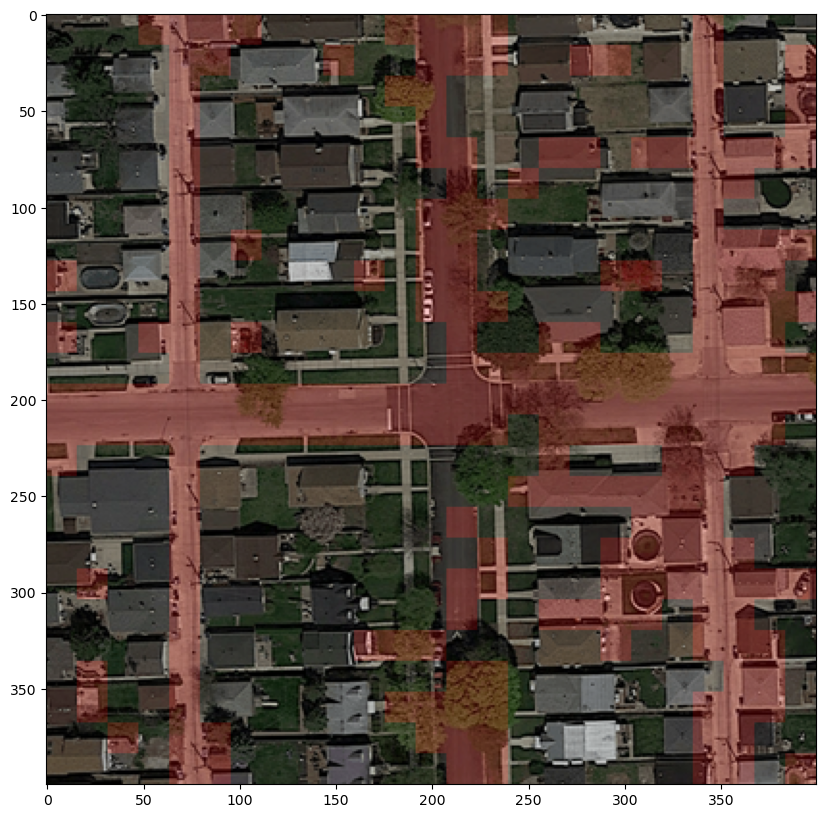

In [23]:
IMG_PATCH_SIZE = 16
img_idx = 0
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
print(np_array.shape)
predicted_im = label_to_img(w, h, IMG_PATCH_SIZE, IMG_PATCH_SIZE, np_array)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

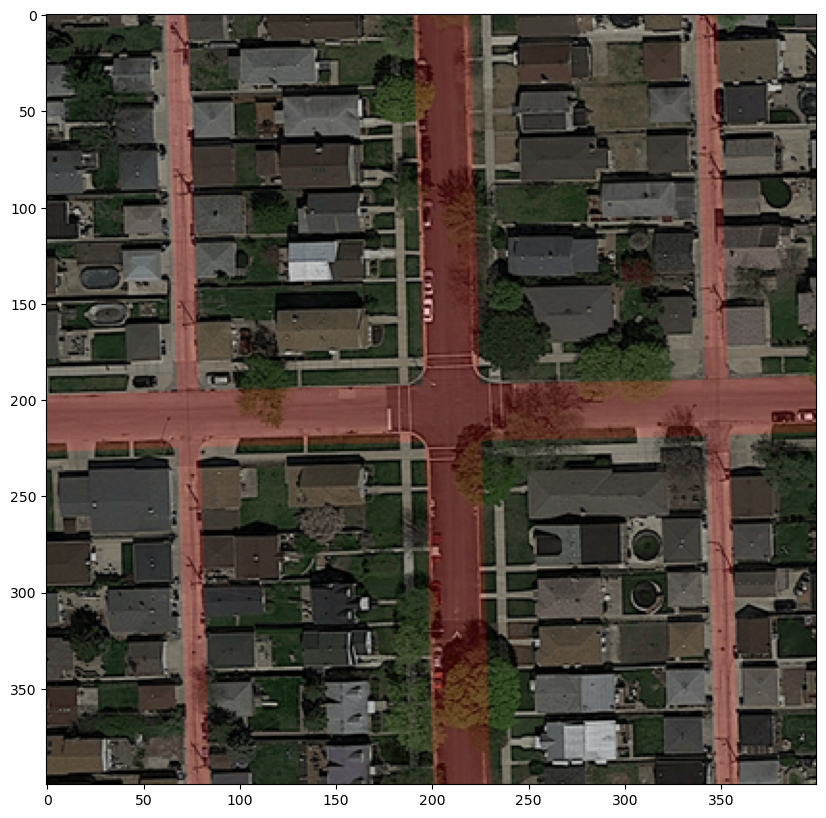

In [24]:
cimg = concatenate_images(imgs[img_idx], gt_imgs[img_idx])
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx],  gt_imgs[img_idx])

plt.imshow(new_img)

Let's test our model on the test set!

In [25]:
def load_image_test(infilename, index):
    infilename_with_index = f"{infilename}test_{index}/test_{index}.png"  
    data = mpimg.imread(infilename_with_index)
    return data

In [26]:
num_test_images = 20
# Loaded a set of images
root_dir = "data/test_set_images/"

image_dir = root_dir + "test_set_images/"
dirs = os.listdir(image_dir)
n = min(num_test_images, len(dirs))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs_test = [load_image_test(image_dir, i+1) for i in range(n)]

print(len(imgs_test[0]))
img_patches_test = [img_crop(imgs_test[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(n)]
print(len(img_patches_test))
data_test = np.asarray(
    [
        img_patches_test[i][j]
        for i in range(len(img_patches_test))
        for j in range(len(img_patches_test[i]))
    ]
)
test_img_patches = numpy.asarray(data_test)
print(test_img_patches.shape)


Loading 20 images
608
20
(28880, 16, 16, 3)


In [27]:
test_dataset = CustomDataset(test_img_patches)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = torch.nn.functional.cross_entropy

preds_test = get_predictions(model, "cpu", test_loader, criterion)
print(preds_test)

[tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0])

In [28]:
test_array = np.array([t.item() for t in preds_test])
print(test_array.shape)
images = test_array.reshape(20, -1)
print(images.shape)


(28880,)
(20, 1444)


(1444,)
608 608 16 16
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


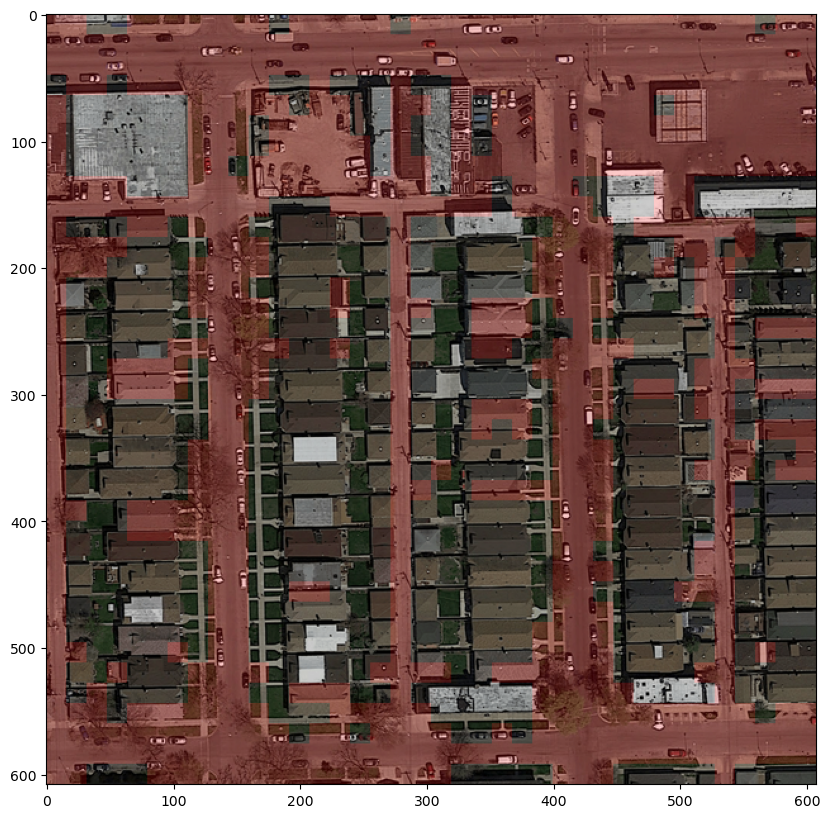

In [38]:
IMG_PATCH_SIZE = 16
img_idx = 0
w = imgs_test[img_idx].shape[0]
h = imgs_test[img_idx].shape[1]
print(images[img_idx].shape)

predicted = []
for i in range(0, 1):#num_test_images
    predicted_im = label_to_img(w, h, IMG_PATCH_SIZE, IMG_PATCH_SIZE, images[i])
    print(predicted_im)
    cimg = concatenate_images(imgs_test[i], predicted_im)
    fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
    plt.imshow(cimg, cmap="Greys_r")
    predicted.append(predicted_im)

    new_img = make_img_overlay(imgs_test[i], predicted_im)

    plt.imshow(new_img)

In [41]:
img = Image.fromarray(predicted_im, mode='L')
img.save("Ground_test_1.png")

In [ ]:
import re
foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

#I don't understand for the moment how to use the functions from mask_to_submission
#masks_to_submission("submission_17_11_16_16", predicted[0])

TypeError: cannot use a string pattern on a bytes-like object